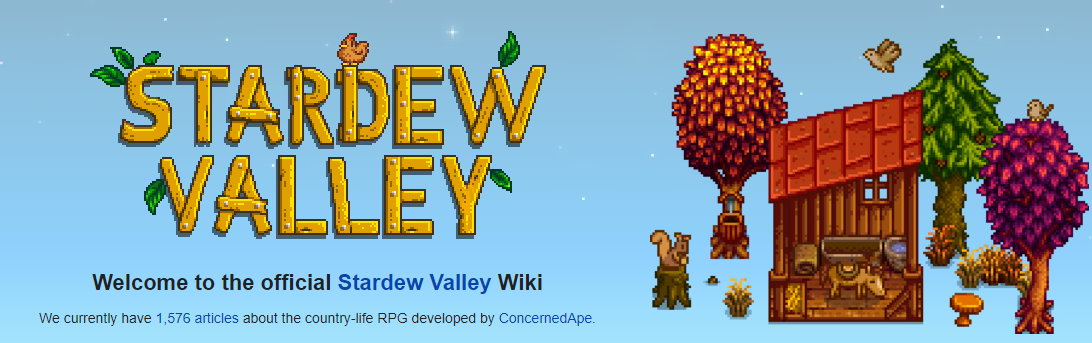

## Stardew Valley Crop Information

I love Stardew Valley - nothing more to be said. I spend a lot of time on the wiki looking up crop information and I got curious about how I could compile all that info into some graphs. Having just started my career in data science, I wanted to put some new found skills into action and explore the data from a game I adore.

performed using the tutorial from JustIntoData

want to extract: crop name, base sell price, growth days, gold per day (base) and season

So let's get started!

In [1]:
# import required packages
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Initial Web Scraping
The easiest way to retrieve all of the crop names was from the /Crops page. As I wanted to get information relating to artisan goods I couldn't just use this page to get growth time, season info and sell prices. The print out's here just verify what page I visited and if it was successful (200 means we're all good!)

In [2]:
# request website's data
response = requests.get('https://stardewvalleywiki.com/Crops')
print('Visited URL: {}'.format(response.url))
print(response.status_code)

Visited URL: https://stardewvalleywiki.com/Crops
200


Let's save the webpage html so we don't have to continously keep accessing the page - this is good practice because we don't want to take up the page's bandwidth

In [4]:
#parse HTML doc with BeautifulSoup
soup = BeautifulSoup(response.text, 'html.parser')

In [5]:
# write to html
with open("crops.html", "w", encoding='utf-8') as file:
    file.write(str(soup))

### From HTML File

We can then just reload our saved html and work from there

In [54]:
#open html
with open("crops.html", encoding = 'utf-8') as fp:
    soup = BeautifulSoup(fp, 'html.parser')

#### Find headings

Let's first look at the output of soup and identify the headings that are our crop names. We have to scroll quite far but eventually we will find our headings. The span class `toctext` is what we will use to extract the text.

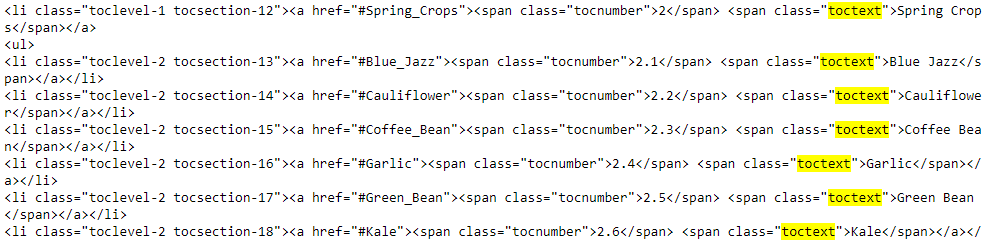

In [20]:
#extract all div tags with the specific class we want
crop_name = soup.find_all('span',class_='toctext')

#loop through div tags to create list of text only
all_crop_names = []
for name in crop_name:
    crop = name.text
    all_crop_names.append(crop)
    
print(all_crop_names)

['Basics', 'Monsters', 'Crows', 'Farm Animals', 'Fertilizing and Planting', 'Trellis Crops', 'Grow Times', 'End of Season', 'Giant Crops', 'Crop Quality', 'Gold per Day', 'Spring Crops', 'Blue Jazz', 'Cauliflower', 'Coffee Bean', 'Garlic', 'Green Bean', 'Kale', 'Parsnip', 'Potato', 'Rhubarb', 'Strawberry', 'Tulip', 'Unmilled Rice', 'Summer Crops', 'Blueberry', 'Corn', 'Hops', 'Hot Pepper', 'Melon', 'Poppy', 'Radish', 'Red Cabbage', 'Starfruit', 'Summer Spangle', 'Sunflower', 'Tomato', 'Wheat', 'Fall Crops', 'Amaranth', 'Artichoke', 'Beet', 'Bok Choy', 'Cranberries', 'Eggplant', 'Fairy Rose', 'Grape', 'Pumpkin', 'Yam', 'Winter Crops', 'Special Crops', 'Ancient Fruit', 'Cactus Fruit', 'Fiber', 'Mixed Seeds', 'Pineapple', 'Taro Root', 'Sweet Gem Berry', 'Tea Leaves', 'Wild Seeds', 'Artisan Goods', 'Achievements', 'Notes', 'External Links', 'References', 'History']


As this was the overview page of all the crops, there are many headings that are irrelevant like "Basics", "Monsters", etc. All we need is from Blue Jazz to Sweet Gem berry.

In [21]:
#filter for just crops
all_extracted_names = all_crop_names[all_crop_names.index("Blue Jazz"): all_crop_names.index("Tea Leaves")]

In [59]:
print(all_extracted_names)

['Blue Jazz', 'Cauliflower', 'Coffee Bean', 'Garlic', 'Green Bean', 'Kale', 'Parsnip', 'Potato', 'Rhubarb', 'Strawberry', 'Tulip', 'Unmilled Rice', 'Summer Crops', 'Blueberry', 'Corn', 'Hops', 'Hot Pepper', 'Melon', 'Poppy', 'Radish', 'Red Cabbage', 'Starfruit', 'Summer Spangle', 'Sunflower', 'Tomato', 'Wheat', 'Fall Crops', 'Amaranth', 'Artichoke', 'Beet', 'Bok Choy', 'Cranberries', 'Eggplant', 'Fairy Rose', 'Grape', 'Pumpkin', 'Yam', 'Winter Crops', 'Special Crops', 'Ancient Fruit', 'Cactus Fruit', 'Fiber', 'Mixed Seeds', 'Pineapple', 'Taro Root', 'Sweet Gem Berry']


We still have a few unnecessary headings that aren't crops, so let's manually remove these

In [60]:
# list of non-crops
not_crops = ['Summer Crops', 'Fall Crops', 'Winter Crops', 'Special Crops', 'Fiber', 'Mixed Seeds']

# remove non-crops
all_crop_names = [name for name in all_extracted_names if name not in not_crops]

In [61]:
print(all_crop_names)

['Blue Jazz', 'Cauliflower', 'Coffee Bean', 'Garlic', 'Green Bean', 'Kale', 'Parsnip', 'Potato', 'Rhubarb', 'Strawberry', 'Tulip', 'Unmilled Rice', 'Blueberry', 'Corn', 'Hops', 'Hot Pepper', 'Melon', 'Poppy', 'Radish', 'Red Cabbage', 'Starfruit', 'Summer Spangle', 'Sunflower', 'Tomato', 'Wheat', 'Amaranth', 'Artichoke', 'Beet', 'Bok Choy', 'Cranberries', 'Eggplant', 'Fairy Rose', 'Grape', 'Pumpkin', 'Yam', 'Ancient Fruit', 'Cactus Fruit', 'Pineapple', 'Taro Root', 'Sweet Gem Berry']


Now we have a list of all the available crops.  
<br>
To get information like type, season, sell prices, etc. about each crop we will need to visit each crop's page. 
To do this we need to replace the spaces in two word names with an underscore, that way we can add it to the URL 
and go straight there.

In [ ]:
#replace spaces in names with _ to read id in next step 
all_crop_names = [x.replace(" ", "_") for x in all_crop_names]

#### Functions to get base price, crop type, growth time, season and seed cost

In [63]:
#write base price extraction into function
def baseprice(soup_obj):
    
    #find correct tag in soup object
    table = soup_obj.find_all('table', class_='no-wrap') 
    
    #search through the found tag at index 1 to find prices
    search = re.search("([0-9]*.g){1}",table[1].text)
    #save matched value
    match = search.group()
    #drop g for int
    base_price = match.replace('g','')
        
    return int(base_price)

In [9]:
def crop_type(all_crop_names):
    '''
    All_crop_names should be passed as a list
    '''
    if (all_crop_names in ['Coffee_Bean', 'Sweet_Gem_Berry']) == True:
        return 'other'
    elif(all_crop_names == 'Cactus_Fruit') == True:
        return 'fruit'
    else:
        type_crop = crophtml.find_all('a')

        for c in range(0,len(type_crop)):
            if (type_crop[c].text in ["flower",'vegetable','fruit']) == True:
                   return (type_crop[c].text)

In [65]:
#create empty lists to append data to
crop_name = []
crop_type = []
season = []
base_price = []
growth_time = []
seed_price = []


for name in all_crop_names:
    
    #save crop name to list
    crop_name.append(name)
    
    #request website's data for each crop name
    web_url = 'https://stardewvalleywiki.com/' + name
    response = requests.get(web_url)
    
    #read html
    soup = BeautifulSoup(response.text, 'html.parser')
    
    #get base price using function
    if name != 'Sweet_Gem_Berry':
        base_price.append(baseprice(soup))
    else: # fruit is Sweet Gem Berry
        text = str(table[0].text).replace(',','')
        search = re.search("([0-9]*g)",text)
        match = search.group()
        sg_base_price = match.replace('g','')
        base_price.append(sg_base_price)
        
    #get type flower,vegetable,fruit
    if (name in ['Coffee_Bean', 'Sweet_Gem_Berry']) == True:
        crop_type.append('other')
    elif(name == 'Cactus_Fruit') == True:
        crop_type.append('fruit')
    else:
        type_crop = soup.find_all('a')

        for c in range(0,len(type_crop)):
            if (type_crop[c].text in ["flower",'vegetable','fruit']) == True:
                crop_type.append(type_crop[c].text)
    
    #get growth time and season
    #info headers to match info to
    all_infoboxsection = soup.find_all('td',id='infoboxsection') 
    #gets info
    all_infoboxdetail = soup.find_all('td', id = 'infoboxdetail') 
    
    for i in range(1,len(all_infoboxdetail)):
        
        #for growth time header
        if all_infoboxsection[i].text == "Growth Time":
            time = all_infoboxdetail[i].text
            #drop days from time text
            time_int = time.replace('days', '')
            
            #if time is not x days (Grape, Rice, Taro)
            if len(time_int) > 3:
                search = re.findall("\d+", time_int)
                growth_time.append(search[-1])
            else:
                growth_time.append(time_int)
        
        #for season header        
        if all_infoboxsection[i].text == "Season":
            season_str = all_infoboxdetail[i].text
            season_str = season_str.replace(" ","")
            
            #if multiple seasons
            if len(season_str.split()) > 1:
                season.append("Special")
            #(cactus fruit)
            elif 'All' in season_str:
                season.append("Special")
            else:
                season.append(season_str)
        
#         #seed price info
#         if all_infoboxsection[i].text == "Seed":
#             seed = all_infoboxdetail[i].text
#             seed = seed.replace(" ","_")
#             web_url_seed = 'https://stardewvalleywiki.com/' + seed
#             res = requests.get(web_url_seed)

#             seed_soup = BeautifulSoup(res.text,'html.parser')

#             #get crop type: vegetable, flower, fruit

#             seed_site = seed_soup.find('table',id = 'infoboxtable')

#             seed_pp = seed_site.find_all('td', id = 'infoboxsection')
#             seed_pv = seed_site.find_all('td', id = 'infoboxdetail')


#             for j in range(0, len(seed_pp)):
#                 if ('Purchase Prices' in seed_pp[j].text) == True:
#                     sp = re.findall('\d{1,4}g', seed_pv[j].text)
#                     seed_val = sp[0].replace(',','').replace('g','')
#                     seed_price.append(int(seed_val))
    
    #progress indicator        
    if name == 0:
        print('Starting...')
    elif name == len(all_crop_names)/2:
        print('Halfway!')
    elif name == len(all_crop_names)-1:
        print("Done! ^-^")

IndexError: list index out of range

In [11]:
#check - all should be 40
print(len(crop_name), len(seed_price), len(crop_type), len(base_price), len(growth_time), len(season))

40 0 40 40 40 40


Create and clean up data frame

In [12]:
#remove _ from crop names
converter = lambda x: x.replace('_', ' ')
crop_list = list(map(converter, crop_name))

#create dictionary of lists to pass into dataframe
dict = {'crop_name': crop_list, 'crop_type' : crop_type, 'base_price': base_price,
       'growth_time': growth_time, 'season': season}

cropinfo_df = pd.DataFrame(dict)

#remove unicode xa0 from seasons
cropinfo_df['season'] = cropinfo_df['season'].apply(lambda x: str(x).replace(u'\xa0', u''))

#order seasons
cropinfo_df['season'] = pd.Categorical(cropinfo_df['season'],['Spring','Summer','Fall','Special'])

#convert growth time to integer
cropinfo_df['growth_time'] = pd.to_numeric(cropinfo_df['growth_time'])



Because we had to re-scrap more websites let's save this dataframe to a csv file

Add gold per day, preserving and kegging gpd values

In [13]:
#calculate gpd when preserved
def artisan(df, artisan_type = 'preserve', profession = 'base'):
    
    artisan_price = []
        
    column = df['base_price']
    
    df_dict = df.to_dict(orient = 'records')
    
    for e in range(0,len(df_dict)):
    
        if (df_dict[e]['crop_type'] in ['vegetable','fruit']) == True:
            
            if artisan_type == 'preserve':
                jar_price = 2 * column[e] + 50

                if profession == 'artisan':
                    artisan_price.append(round(jar_price + 0.4 * jar_price))
                else:
                    artisan_price.append(round(jar_price))

            if artisan_type == 'keg':
                if df_dict[e]['crop_type'] == 'vegetable':
                    juice_price = 2.25 * column[e]

                    if profession == 'artisan':
                        artisan_price.append(round(juice_price + 0.4 * juice_price))
                    else:
                        artisan_price.append(round(juice_price))

                if df_dict[e]['crop_type'] == 'fruit':
                    wine_price = 3 * column[e]

                    if profession == 'artisan':
                        artisan_price.append(round(wine_price + 0.4 * wine_price))
                    else:
                        artisan_price.append(round(wine_price))

        else:
            artisan_price.append(np.nan)

    return artisan_price

In [14]:
#calculate gold per day, preserve and keg prices, and honey prices
#all productivyt values are g/min
cropinfo_df['gold_per_day'] = round(cropinfo_df['base_price']/cropinfo_df['growth_time'], 2)

cropinfo_df['preserve_price'] = artisan(cropinfo_df)
cropinfo_df['preserve_productivity'] = (cropinfo_df['preserve_price'] - cropinfo_df['base_price']) / 4000 #processing time is always 4000 minutes

cropinfo_df['keg_price'] = artisan(cropinfo_df,'keg')
#juice is 6000 min, wine is 10000min
cropinfo_df['keg_productivty'] = np.where(cropinfo_df['crop_type'] == 'fruit', (cropinfo_df['keg_price'] - cropinfo_df['base_price']) / 10000, np.where(cropinfo_df['crop_type'] == 'vegetable', (cropinfo_df['keg_price'] - cropinfo_df['base_price'])/6000, np.nan))


cropinfo_df['honey_price'] = np.where(cropinfo_df['crop_type'] == 'flower', 100 + cropinfo_df['base_price'] * 2, np.nan)
cropinfo_df['honey_productivity'] = cropinfo_df['honey_price'] / 6100 #honey process time is 6100 m

In [15]:
cropinfo_df

,crop_name,crop_type,base_price,growth_time,season,gold_per_day,preserve_price,preserve_productivity,keg_price,keg_productivty,honey_price,honey_productivity
0,Blue Jazz,flower,50,7,Spring,7.14,NaN,NaN,NaN,NaN,200.0,0.032787
1,Cauliflower,vegetable,175,12,Spring,14.58,400.0,0.05625,394.0,0.036500,NaN,NaN
2,Coffee Bean,other,150,10,Special,15.00,NaN,NaN,NaN,NaN,NaN,NaN
3,Garlic,vegetable,60,4,Spring,15.00,170.0,0.02750,135.0,0.012500,NaN,NaN
4,Green Bean,vegetable,40,10,Spring,4.00,130.0,0.02250,90.0,0.008333,NaN,NaN
5,Kale,vegetable,110,6,Spring,18.33,270.0,0.04000,248.0,0.023000,NaN,NaN
6,Parsnip,vegetable,35,4,Spring,8.75,120.0,0.02125,79.0,0.007333,NaN,NaN
7,Potato,vegetable,80,6,Spring,13.33,210.0,0.03250,180.0,0.016667,NaN,NaN
8,Rhubarb,fruit,242,13,Spring,18.62,534.0,0.07300,726.0,0.048400,NaN,NaN
9,Strawberry,fruit,120,8,Spring,15.00,290.0,0.04250,360.0,0.024000,NaN,NaN


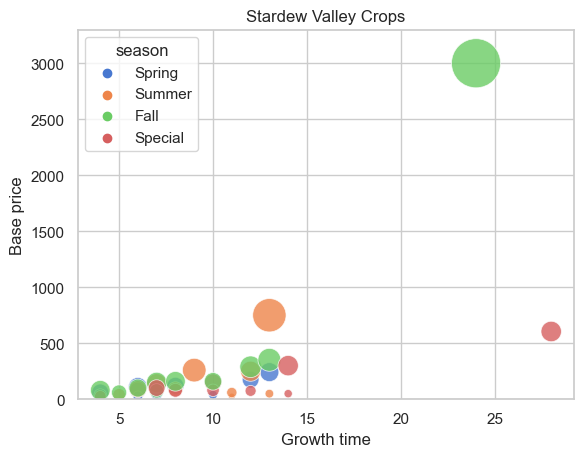

In [37]:
sns.set_theme(style = 'whitegrid', palette = 'muted')

sns.scatterplot(x = cropinfo_df['growth_time'],
           y = cropinfo_df['base_price'],
           s = cropinfo_df['gold_per_day']*10,
            hue = cropinfo_df['season'], 
            alpha = 0.8)

plt.title("Stardew Valley Crops")
plt.xlabel('Growth time')
plt.ylim(0, 3300)
plt.ylabel('Base price')

plt.show()

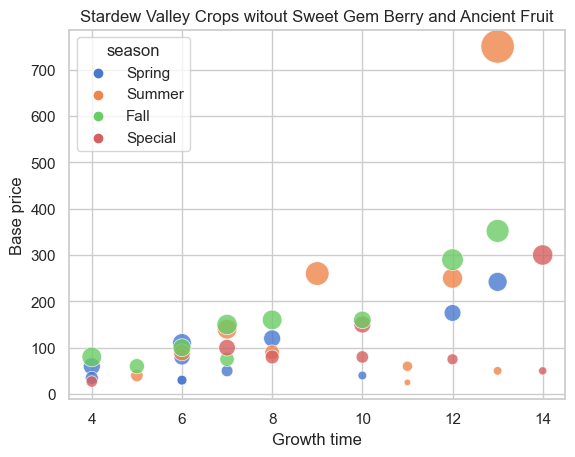

In [38]:
sns.set_theme(style = 'whitegrid', palette = 'muted')

data = cropinfo_df[cropinfo_df['growth_time']< 20]

sns.scatterplot(x = data['growth_time'],
           y = data['base_price'],
           s = data['gold_per_day']*10,
            hue = data['season'], 
            alpha = 0.8)

plt.title("Stardew Valley Crops witout Sweet Gem Berry and Ancient Fruit")
plt.xlabel('Growth time')
#plt.ylim(0, 3300)
plt.ylabel('Base price')

plt.show()

<Axes: xlabel='season', ylabel='gold_per_day'>

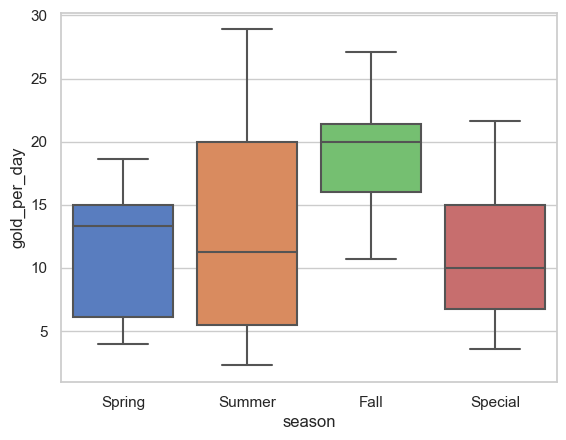

In [39]:
gpd = cropinfo_df[cropinfo_df['gold_per_day']< 50]

sns.boxplot(data = gpd, x = 'season', y = 'gold_per_day')


TypeError: 'str' object is not callable

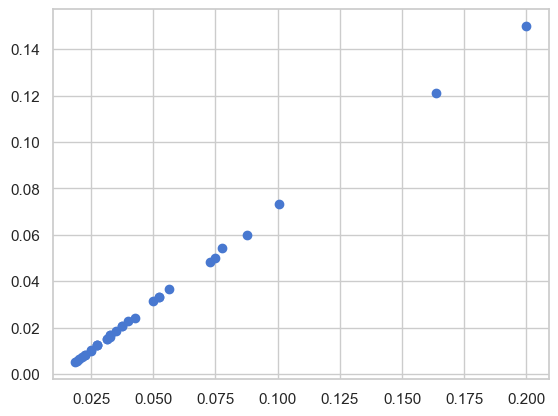

In [49]:
plt.scatter(x = cropinfo_df['preserve_productivity'], y = cropinfo_df['keg_productivty'])
plt.ylabel('Keg')
plt.xlabel('Preserve')
plt.yticks(range)

#### TESTING

In [507]:
#request website's data for each crop name

crop_name = 'Peach_Sapling'
web_url = 'https://stardewvalleywiki.com/' + crop_name 

res = requests.get(web_url)
print('Visited URL: {}'.format(response.url))
print(response.status_code)

Visited URL: https://stardewvalleywiki.com/Peach_Sapling
200


In [508]:
#parse HTML doc with BeautifulSoup
soup = BeautifulSoup(res.text, 'html.parser')

print(soup.prettify())

<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="utf-8"/>
  <title>
   Peach Sapling - Stardew Valley Wiki
  </title>
  <script>
   document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"81878efb42470f07ba379f14","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"Peach_Sapling","wgTitle":"Peach Sapling","wgCurRevisionId":143054,"wgRevisionId":143054,"wgArticleId":3607,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Saplings"],"wgPageContentLanguage":"en","wgPageContentModel":"wikitext","wgRelevantPageName":"Peach_Sapling","wgRelevantArticleId":3607,"wgIsProbablyEditable":!1,

In [529]:
web_url_seed = 'https://stardewvalleywiki.com/Peach_Sapling'
res = requests.get(web_url_seed)

seed_soup = BeautifulSoup(res.text,'html.parser')

#get crop type: vegetable, flower, fruit

seed_site = seed_soup.find('table',id = 'infoboxtable')

seed_pp = seed_site.find_all('td', id = 'infoboxsection')
seed_pv = seed_site.find_all('td', id = 'infoboxdetail')


for j in range(0, len(seed_pp)):
    if ('Purchase Prices' in seed_pp[j].text) == True:
        sp = re.findall('\d.{1,4}g$', seed_pv[j].text)
        seed_price = int(sp[0].replace(',','').replace('g',''))

        

print(i, seed, res, seed_price)

6 _Rare_Seed <Response [200]> 6000


In [531]:
infotable = soup.find('table',id = 'infoboxtable')



#gets growth time and season
all_infoboxsection = infotable.find_all('td',id='infoboxsection') #gets row name
all_infoboxdetail = infotable.find_all('td', id = 'infoboxdetail') #gets row value
#does not get base price


for i in range(0,len(all_infoboxdetail)):
    if all_infoboxsection[i].text == "Growth Time":
        time = all_infoboxdetail[i].text
        time_int = time.replace('days', '')
        if len(time_int) > 3:
            search = re.findall("\d+", time_int)
            print(search[-1])
            
    if all_infoboxsection[i].text == "Season":
        season_str = all_infoboxdetail[i].text

        #if multiple seasons
        if len(season_str.split()) > 1:
            print("Special")
        #(cactus fruit)
        elif 'All' in season_str:
            print("Special")
        else:
            print(season_str)
        
    if all_infoboxsection[i].text == "Seed":
        seed = all_infoboxdetail[i].text
        seed = seed.replace(" ","_")
        web_url_seed = 'https://stardewvalleywiki.com/' + seed
        res = requests.get(web_url_seed)
        
        seed_soup = BeautifulSoup(res.text,'html.parser')
        
        #get crop type: vegetable, flower, fruit

        seed_site = seed_soup.find('table',id = 'infoboxtable')

        seed_pp = seed_site.find_all('td', id = 'infoboxsection')
        seed_pv = seed_site.find_all('td', id = 'infoboxdetail')


        for j in range(0, len(seed_pp)):
            if ('Purchase Prices' in seed_pp[j].text) == True:
                sp = seed_pv[j].text#re.findall('\d.{1,4}g$', seed_pv[j].text)
                #print(int(sp[0].replace(',','').replace('g','')))

        

    print(i, seed, res, sp)


0 _Rare_Seed <Response [200]> Not Sold

1 _Rare_Seed <Response [200]> Not Sold

2 _Rare_Seed <Response [200]> Not Sold

3 _Rare_Seed <Response [200]> Not Sold

4 _Rare_Seed <Response [200]> Not Sold

5 _Rare_Seed <Response [200]> Not Sold

6 _Rare_Seed <Response [200]> Not Sold

7 _Rare_Seed <Response [200]> Not Sold



In [ ]:
baseprice(soup)